In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from hyperopt import hp, tpe, fmin
from scipy.stats import chi2_contingency, pointbiserialr 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("/content/heart_failure_clinical_records_dataset.csv")

In [4]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [13]:
df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

The data is inbalanced.

In [19]:
cat_feature = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

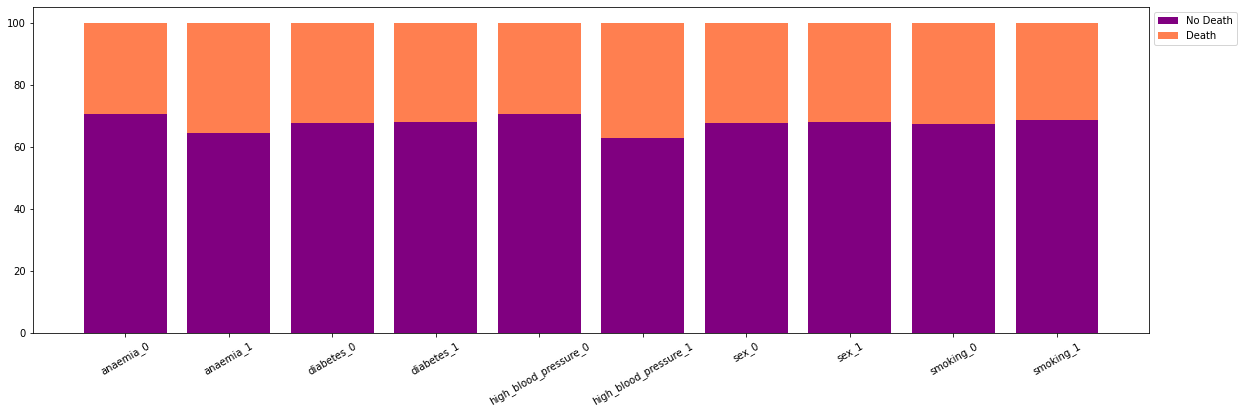

In [219]:
death_t = []
death_f = []
names = []
x_tick = list(range(len(cat_feature) * 2))
for i in cat_feature:
    sub_group = df.groupby(i).DEATH_EVENT.value_counts().to_list()
    for j in range(2):
        death_f.append(sub_group[j * 2])
        death_t.append(sub_group[j * 2 + 1])
        names.append(i + "_" + str(j))
total = [i + j for i, j in zip(death_t, death_f)]
death_0 = [i/j * 100 for i, j in zip(death_f, total)]
death_1 = [i/j * 100 for i, j in zip(death_t, total)]
plt.figure(figsize=(20, 6))
plt.bar(x_tick, death_0, label = "No Death", width=0.8, color = "purple")
plt.bar(x_tick, death_1, bottom = death_0, label = "Death", width=0.8, color = "coral")
plt.xticks(x_tick, names, rotation = 30)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

From the plot we could roughly tell that death rate does not vary within these groups, meaning that these features do not associate with the dependent variables. This could be further proved by doing chi-squre test.

In [20]:
for i in cat_feature:
    crosstab = pd.crosstab(df[i], df.DEATH_EVENT)
    p_value = chi2_contingency(crosstab)[1]
    if p_value > 0.05:
        print("p values " + str(p_value))
        print("There is no association between death_event and " + i)
    else:
        print("p values " + str(p_value))
        print("There is association between death_event and " + i)

p values 0.3073160508415107
There is no association between death_event and anaemia
p values 0.9267235137291102
There is no association between death_event and diabetes
p values 0.21410341199416902
There is no association between death_event and high_blood_pressure
p values 0.9560508538247334
There is no association between death_event and sex
p values 0.9317652998235507
There is no association between death_event and smoking


In [28]:
num_feature = df.columns.tolist()
for i in df.columns.tolist():
    if i in cat_feature:
        num_feature.remove(i)
num_feature.remove("DEATH_EVENT")

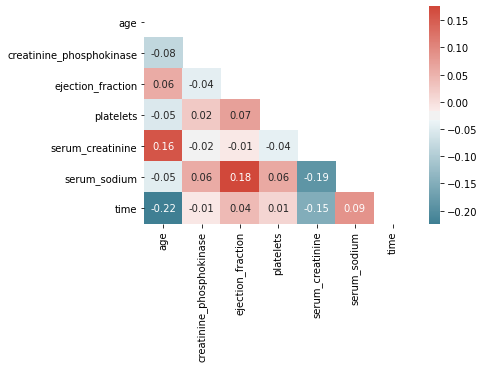

In [212]:
sns.heatmap(df[num_feature].corr(),annot=True,fmt=".2f", cmap=sns.diverging_palette(220, 15, as_cmap=True), mask=np.triu(np.ones_like(df[num_feature].corr(), dtype=np.bool)))

The numerical features don't correlate with each other. As the dependent variable is a categorical varibale, point biserial test will be used to test the associate between dependent varibale and the numerical independent varibales.

In [40]:
features = []
for i in num_feature:
    pb, p = pointbiserialr(df[i], df.DEATH_EVENT)
    print(pb, p)
    if abs(pb) > 0.2 or p < 0.05:
        print("Associate between death and " +i)
        features.append(i)
    else:
        print("No associate between death and " + i)
features

0.2537285430880036 8.916762946531661e-06
Associate between death and age
0.06272816025237474 0.27961124573610285
No associate between death and creatinine_phosphokinase
-0.26860331239406215 2.4528974182084116e-06
Associate between death and ejection_fraction
-0.04913886798037426 0.39719415404131725
No associate between death and platelets
0.2942775609841492 2.1901978548976176e-07
Associate between death and serum_creatinine
-0.19520359641640114 0.0006889112363762405
Associate between death and serum_sodium
-0.5269637792775771 9.122223384924461e-23
Associate between death and time


['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']

After removing the features that do not correlate with the dependent variables, smote is used to balanced this dataset. The numerical features were scaled to fit the models.

In [208]:
smote = SMOTE(random_state = 1)
scaler = StandardScaler()
new_df = scaler.fit_transform(df.loc[:, features].copy())
target =df["DEATH_EVENT"]
X_train, X_test, y_train, y_test = train_test_split(new_df, target, random_state = 1)
X_train, y_train = smote.fit_resample(X_train, y_train)
models = [LogisticRegression(), LGBMClassifier(), SVC()]
for model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(preds, y_test)
    acc = accuracy_score(preds, y_test)
    print(str(model) + " : " + str(f1) + " , " + str(acc))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) : 0.7441860465116279 , 0.8533333333333334
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) : 0.7826086956521738 , 0.8666666666666667
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scal

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fine tune the hyperparameters of models

In [162]:
space = {'n_estimators':hp.quniform('n_estimators', 100, 5000, 50),
         'learning_rate':hp.uniform('learning_rate', 0.0001, 0.1),
         'max_depth':hp.quniform('max_depth', 3,15,1),
         'num_leaves':hp.quniform('num_leaves', 50, 1000, 50),
         'min_child_samples':hp.quniform('min_child_samples', 10, 100, 10),
         "reg_alpha":hp.loguniform("reg_alpha", 0.00001, 1),
         "reg_lambda":hp.loguniform("reg_lambda", 0.00001, 1)
        }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'num_leaves': int(params['num_leaves']),
             'min_child_samples': int(params['min_child_samples']),
             "reg_alpha" : params["reg_alpha"], 
             "reg_lambda": params["reg_lambda"]
}
    
    lgbm= LGBMClassifier(**params)
    score = cross_val_score(lgbm, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1).mean()
    return score


In [163]:
best1 = fmin(fn= objective, space= space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)
best1

100%|██████████| 20/20 [00:10<00:00,  1.83it/s, best loss: 0.8239194006253922]


{'learning_rate': 0.07337014913503634,
 'max_depth': 7.0,
 'min_child_samples': 90.0,
 'n_estimators': 3750.0,
 'num_leaves': 650.0,
 'reg_alpha': 1.9609497194337724,
 'reg_lambda': 1.1235424520289674}

In [164]:
lgbm_b = LGBMClassifier(random_state=0,
                        n_estimators=int(best1['n_estimators']), 
                        learning_rate= best1['learning_rate'],
                        max_depth= int(best1['max_depth']),
                        num_leaves= int(best1['num_leaves']),
                        min_child_samples= int(best1['min_child_samples']),
                        reg_alpha = best1["reg_alpha"],
                        reg_lambda = best1["reg_lambda"]
                       )
lgbm_b.fit(X_train, y_train)
preds_lgbm = lgbm_b.predict(X_test)
acc_lgbm = accuracy_score(preds_lgbm, y_test)
f1_lgbm = f1_score(preds_lgbm, y_test)
print(acc_lgbm, f1_lgbm)

0.8666666666666667 0.7826086956521738


The accuracy and f1 score on the test set by lgboost is 87%, 0.78

Fine tune a logistic regression model

In [173]:
space_l = {'C':hp.loguniform('C', 0.0001, 1),
           'max_iter':hp.quniform('max_iter',50, 500, 50),
        }

def objective_l(params):
    params = {'C': int(params['C']),
             'max_iter': int(params['max_iter'])
}
    
    lr= LogisticRegression(**params)
    score = cross_val_score(lr, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1).mean()
    return score


In [174]:
best_l = fmin(fn= objective_l, space= space_l, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)
best_l

100%|██████████| 20/20 [00:01<00:00, 13.70it/s, best loss: 0.8039500578706285]


{'C': 1.9682538126201339, 'max_iter': 150.0}

In [175]:
lr_b = LogisticRegression(random_state=0, 
                          C=best_l["C"],
                          max_iter = best_l["max_iter"])

lr_b.fit(X_train, y_train)
preds_lr = lr_b.predict(X_test)
acc_lr = accuracy_score(preds_lr, y_test)
f1_lr = f1_score(preds_lr, y_test)
print(acc_lr, f1_lr)

0.8533333333333334 0.7441860465116279


The accuracy and f1 score on the test set by logistic regression is 85%, 0.74

Random Forest do not require the numerical features scaled. Use the unscaled data to train a random forest classifier and fine tuend the hyperparameters/

In [165]:
df_tree = df.loc[:, features].copy()
target =df["DEATH_EVENT"]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(df_tree, target, random_state = 1)
X_train_t, y_train_t = smote.fit_resample(X_train_t, y_train_t)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [170]:
space_t = {'n_estimators':hp.quniform('n_estimators', 100, 1000, 100),
           'criterion':hp.choice('criterion', ("gini", "entropy")),
           'max_depth':hp.quniform('max_depth', 3,15,1)
        }

def objective_t(params):
    params = {'n_estimators': int(params['n_estimators']),
              'criterion': params['criterion']
}
    
    rf= RandomForestClassifier(**params)
    score = cross_val_score(rf, X_train_t, y_train_t, scoring='f1_weighted', cv=5, n_jobs=-1).mean()
    return score


In [171]:
best = fmin(fn= objective_t, space= space_t, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 20/20 [01:27<00:00,  4.38s/it, best loss: 0.8545852177489621]


In [172]:
criterion = ("gini", "entropy")
rf_b = RandomForestClassifier(random_state=0,
                              n_estimators=int(best['n_estimators']), 
                              criterion = cretiron[best["criterion"]])
rf_b.fit(X_train_t, y_train_t)
preds_rf = rf_b.predict(X_test_t)
acc_rf = accuracy_score(preds_rf, y_test_t)
f1_rf = f1_score(preds_rf, y_test_t)
print(acc_rf, f1_rf)

0.8533333333333334 0.7555555555555556


The accuracy and f1 score on the test set by random forest is 85%, 0.76

A simple ensemble method

In [178]:
final_preds = preds_lgbm * 3 + preds_lr + preds_rf * 2
final_preds = (final_preds > 3)
f1_final = f1_score(final_preds, y_test)
acc_final = accuracy_score(final_preds, y_test)
print(f1_final, acc_final)

0.7906976744186046 0.88


The accuracy and f1 score of the final ensemble model is 88%, 0.79